In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy as scp
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

%matplotlib inline

# Import

In [2]:
#
# assumes list.txt is a list of filenames, formatted as
#
# ./lfw2//Aaron_Eckhart/Aaron_Eckhart_0001.jpg
# ./lfw2//Aaron_Guiel/Aaron_Guiel_0001.jpg
# ...
#
 
files = open( './list.txt' ).readlines()

# Clean

In [3]:
data = np.zeros(( len(files), 250, 250 ))
labels = np.zeros(( len(files), 1 ))
 
# a little hash map mapping subjects to IDs
ids = {}
scnt = 0
 
# load in all of our images
ind = 0
for fn in files:
 
    subject = fn.split('/')[3]
    if subject not in ids:
        ids[ subject ] = scnt
        scnt += 1
    label = ids[ subject ]
 
    tmp_im = np.asarray( Image.open( fn.rstrip() ) )
    data[ ind, :, : ] = tmp_im
    labels[ ind ] = label
    ind += 1
 
# data is (13233, 250, 250)
# labels is (13233, 1)

In [4]:
reduce_factor = 3
# reduce_factor = 10

data = [block_reduce(x, block_size=(reduce_factor, reduce_factor), func=np.max) for x in data]

#### Examples of reduced images

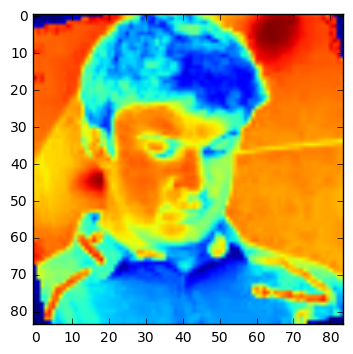

In [5]:
plt.imshow(data[0])

In [6]:
data[0].shape

(84, 84)

In [7]:
# block_reduce(data[0], block_size=(3, 3), func=np.max).shape

In [8]:
# plt.imshow(block_reduce(data[0], block_size=(3, 3), func=np.max))

#  Generate Train/Test

In [9]:
train_ims = []
train_im_classes = []  #  1 == same, 0 == different

#  go through every im sequentially, compare it to the im after and add to training set
#  as a pair with proper label
for i in range((len(labels) - int(0.2 * len(labels))) - 1):
    
    #  if im i is the same as im i+1 then add it to the dataset and label it 1
    if labels[i] == labels[i+1]:
        train_ims.append([data[i], data[i+1]])
        train_im_classes.append(1.0)
        
    #  otherwise they're different classes and should be labeled 0
    else:
        train_ims.append([data[i], data[i+1]])
        train_im_classes.append(0.0)
        
#     if i > 0:
#         #  if im i - 1 is the same as im i+1 then add it to the dataset and label it 1
#         if labels[i-1] == labels[i+1]:
#             train_ims.append([data[i-1], data[i+1]])
#             train_im_classes.append(1.0)

#         #  otherwise they're different classes and should be labeled 0
#         else:
#             train_ims.append([data[i-1], data[i+1]])
#             train_im_classes.append(0.0)
            
#     if i > 1:
#         #  if im i - 2 is the same as im i+1 then add it to the dataset and label it 1
#         if labels[i-2] == labels[i+1]:
#             train_ims.append([data[i-2], data[i+1]])
#             train_im_classes.append(1.0)

#         #  otherwise they're different classes and should be labeled 0
#         else:
#             train_ims.append([data[i-2], data[i+1]])
#             train_im_classes.append(0.0)
    
    
train_ims = np.asarray(train_ims)
train_im_classes = np.asarray(train_im_classes)
        
    
        
test_ims = []
test_im_classes = []  #  1 == same, 0 == different

#  go through every im sequentially, compare it to the im after and add to training set
#  as a pair with proper label
for i in range(len(labels) - int(0.2 * len(labels)), len(labels) -  1):
    
    #  if im i is the same as im i+1 then add it to the dataset and label it 1
    if labels[i] == labels[i+1]:
        test_ims.append([data[i], data[i+1]])
        test_im_classes.append(1.0)
        
    #  otherwise they're different classes and should be labeled 0
    else:
        test_ims.append([data[i], data[i+1]])
        test_im_classes.append(0.0)       
test_ims = np.asarray(test_ims)
test_im_classes = np.asarray(test_im_classes)

In [10]:
#  this looks like a good positive/negative example split to me
print(np.bincount(train_im_classes.astype(int)))
print(np.bincount(test_im_classes.astype(int)))

[4507 6079]
[1241 1404]


In [11]:
def get_next_training_batch(n):
    batch_indexes = np.random.uniform(0, len(train_im_classes), n).astype(int)
    return train_ims[batch_indexes], train_im_classes[batch_indexes]

# Baseline Accuracy

In [12]:
baseline_accuracies = []
for i in range(1000):
    random_y_ = np.random.choice([0,1], len(test_im_classes))
    baseline_accuracies.append(float(np.sum((test_im_classes == random_y_).astype(int))) / \
                               len(test_im_classes))
baseline_accuracy = np.asarray(baseline_accuracies).mean()
baseline_accuracy

0.50007561436672965

# Model

### Parameters

In [13]:
batch_size = 50
n_filters = 10
embedding_len = 128
im_shape_x = train_ims[0][0].shape[0]
im_shape_y = train_ims[0][0].shape[1]

### Graph Declaration

In [14]:
X1 = tf.placeholder(tf.float32, shape=[None, im_shape_x, im_shape_y])
X2 = tf.placeholder(tf.float32, shape=[None, im_shape_x, im_shape_y])
# X1 = tf.placeholder(tf.float32, shape=[batch_size, im_shape_x, im_shape_y])
# X2 = tf.placeholder(tf.float32, shape=[batch_size, im_shape_x, im_shape_y])
Y = tf.placeholder(tf.float32, shape=[None])


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                        strides=[1, 4, 4, 1], padding='SAME')


def resnet_layer(X, W1, W2, b1, b2):
    c1_conv = conv2d(X, W1) + b1
    #  add batch norm
    conv_1 = tf.nn.relu(c1_conv)

    c2_conv = conv2d(conv_1, W2) + b2
    conv_2 = tf.add(c2_conv, X)
    #  add batch norm
    return tf.nn.relu(conv_2)
    

    
    
def resnet_embed(X, passed_scope=None):
    bias_val = 0.1
    
    with tf.variable_scope(passed_scope) as scope:
        
#         import pdb
#         pdb.set_trace()
        
#         res2 = X
        
#         #  initial convolutional layer
        W1_r0 = tf.get_variable("w1r0", [5,5,1,n_filters], tf.float32, tf.random_normal_initializer())
        b1_r0 = tf.get_variable("b1r0", [n_filters], initializer=tf.constant_initializer( bias_val ) )
#         res2 = tf.nn.conv2d(X, W1_r0, [1,1,1,1], "SAME")
        res0_conv = tf.nn.relu(conv2d(X, W1_r0) + b1_r0)
        res0_pool = max_pool_2x2(res0_conv)
        
        
        #  resnet layer 1
        W1_r1 = tf.get_variable("w1r1", [5,5,n_filters,n_filters], tf.float32, tf.random_normal_initializer())
        b1_r1 = tf.get_variable( "b1r1", [n_filters], initializer=tf.constant_initializer( bias_val ) )
        W2_r1 = tf.get_variable("w2r1", [5,5,n_filters,n_filters], tf.float32, tf.random_normal_initializer())
        b2_r1 = tf.get_variable( "b2r1", [n_filters], initializer=tf.constant_initializer( bias_val ) )
        res1 = resnet_layer(res0_pool, W1_r1, W2_r1, b1_r1, b2_r1)


        
        #  resnet layer 2
        W1_r2 = tf.get_variable("w1r2", [5,5,n_filters,n_filters], tf.float32, tf.random_normal_initializer())
        b1_r2 = tf.get_variable( "b1r2", [n_filters], initializer=tf.constant_initializer( bias_val ) )
        W2_r2 = tf.get_variable("w2r2", [5,5,n_filters,n_filters], tf.float32, tf.random_normal_initializer())
        b2_r2 = tf.get_variable( "b2r2", [n_filters], initializer=tf.constant_initializer( bias_val ) )
        res2 = resnet_layer(res1, W1_r2, W2_r2, b1_r2, b2_r2)


#         #  resnet layer 3
#         W1_r3 = tf.get_variable("w1r3", [5,5,n_filters,n_filters], tf.float32, tf.random_normal_initializer())
#         b1_r3 = tf.get_variable( "b1r3", [n_filters], initializer=tf.constant_initializer( bias_val ) )
#         W2_r3 = tf.get_variable("w2r3", [5,5,n_filters,n_filters], tf.float32, tf.random_normal_initializer())
#         b2_r3 = tf.get_variable( "b2r3", [n_filters], initializer=tf.constant_initializer( bias_val ) )
#         res3 = resnet_layer(res2, W1_r3, W2_r3, b1_r3, b2_r3)

    
        #  fully connected layer 1
        W_fc1 = tf.get_variable("wfc1", [res2.get_shape().as_list()[1] * res2.get_shape().as_list()[2] * res2.get_shape().as_list()[3], embedding_len], 
                                tf.float32, tf.random_normal_initializer())
        b_fc1 = tf.get_variable( "bfc1", [embedding_len], initializer=tf.constant_initializer( bias_val ) )
        res2_flat = tf.reshape(res2, [-1, res2.get_shape().as_list()[1] * res2.get_shape().as_list()[2] * res2.get_shape().as_list()[3]])
        gw_embedding = tf.nn.relu(tf.matmul(res2_flat, W_fc1) + b_fc1)
        
        
#         #  fully connected layer 2
#         W_fc2 = tf.get_variable("wfc2", [1000,embedding_len], tf.float32, tf.random_normal_initializer())
#         b_fc2 = tf.get_variable( "bfc2", [embedding_len], initializer=tf.constant_initializer( bias_val ) )
#         gw_embedding = tf.nn.relu(tf.matmul(fc1, W_fc2) + b_fc2)
        
        return gw_embedding
    



def l_g(x):
    return tf.mul(0.5, tf.pow(x, 2))

def l_i(x):
    m = 1.0
    margin_x = tf.maximum(0.0, tf.sub(m, x))
    return tf.mul(0.5, tf.pow(margin_x, 2))



with tf.variable_scope("Siamese") as scope:
    
    X1_reshaped = tf.reshape(X1, [-1, im_shape_x, im_shape_y, 1])
    X2_reshaped = tf.reshape(X2, [-1, im_shape_x, im_shape_y, 1])
    
    with tf.name_scope("ResNet1"):
        G_w1 = resnet_embed(X1_reshaped, "resnet")
        
    scope.reuse_variables()
    
    with tf.name_scope("ResNet2"):
        G_w2 = resnet_embed(X2_reshaped, "resnet")

    



# calculate loss



with tf.name_scope("Loss"):
    # Euclidean distance between G_w1 and G_w2
    E_w = tf.sqrt( tf.reduce_sum(tf.square(tf.sub(G_w1, G_w2)),
                                        reduction_indices=1))

    part_1 = tf.mul(tf.sub(1.0, Y), l_g(E_w))
    part_2 = tf.mul(Y, l_i(E_w))
    L = part_1 + part_2
    L_w = tf.reduce_sum(L)

siam_optim = tf.train.AdamOptimizer(1e-4).minimize(L_w)




with tf.name_scope("Accuracy"):
    E_w_mean = tf.reduce_mean(E_w)
    Y_ = tf.to_float(tf.greater(E_w, E_w_mean))

    accuracy = tf.reduce_mean( tf.to_float(tf.equal(Y_,Y) ) )



In [15]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())


# summaries
summary_writer = tf.train.SummaryWriter("./tf_logs_final/siamese_7", graph=sess.graph)
acc_summary = tf.scalar_summary("accuracy", accuracy)
loss_summary = tf.scalar_summary("loss", L_w)
# merged_summary_op = tf.merge_all_summaries()

batch_ims = None

#  number of epochs to run
for i in range(10000):
    batch = get_next_training_batch(batch_size)
    batch_images = batch[0]
    batch_labels = batch[1]
    
    
    
    sess.run( siam_optim, feed_dict={Y:batch_labels, X1:batch_images[:,0], 
                                    X2:batch_images[:,1]})
    
    

    

#  summaries
    if i % 100 == 0:
        loss_s = sess.run(loss_summary, feed_dict={Y:batch_labels, X1:batch_images[:,0], 
                                X2: batch_images[:,1]})
        acc_s = sess.run(acc_summary, feed_dict={Y:test_im_classes, X1:test_ims[:,0], 
                                        X2: test_ims[:,1]})
        summary_writer.add_summary(loss_s, i)
        summary_writer.add_summary(acc_s, i)
#         loss = sess.run(L_w, feed_dict={Y:batch_labels, X1:batch_images[:,0], 
#                                     X2: batch_images[:,1]})
#         acc = sess.run(accuracy, feed_dict={Y:test_im_classes, X1:test_ims[:,0], 
#                                     X2: test_ims[:,1]})
        
#         print("%f loss,  %f accuracy" % (loss, acc))
#         print("%f loss" % loss)
#         print("%f accuracy" % acc)




#         summary = sess.run([merged_summary_op], feed_dict={})
#         summary_writer.add_summary(summary, i)

summary_writer.close()






KeyboardInterrupt: 

# Evaluate

In [156]:
#  this is the output of batches
results = get_next_training_batch(10)

In [157]:
results[0].shape

(10, 2, 250, 250)

In [158]:
results[1].shape

(10,)

In [159]:
results[0][0][0][0]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,
          4.,    2.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    2.,    2.,    1.,    1.,    0.,    0.,
          0.,    0.,    0.,    1.,    3.,    0.,    0.,    3.,    3.,
          0.,    0.,    0.,    0.,    0.,    2.,    2.,    1.,    0.,
          0.,    0.,    0.,    0.,    0.,    1.,    3.,    3.,    0.,
          0.,    0.,    0.,    0.,    1.,    1.,    2.,    0.,    0.,
          1.,    1.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,
          4.,    1.,    0.,    0.,    2.,    0.,    0.,    0.,    0.,
          0.,    1.,    4.,    0.,    1.,    3.,    1.,    0.,    0.,
          0.,    0.,